# Analysis experiments for so called RADICAL-Pilot paper

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
# mpl.rcParams['text.usetex'] = True 
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 12
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

## Durations

Red durations are currently broken in RP/Analytics.

### Pilots

* 'P_PMGR_SCHEDULING': ['NEW', 'PMGR_LAUNCHING_PENDING'],
* 'P_PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING', 'PMGR_LAUNCHING'],
* 'P_LRMS_SUBMITTING': ['PMGR_LAUNCHING', 'PMGR_ACTIVE_PENDING'],
* 'P_LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING', 'PMGR_ACTIVE'],
* 'P_LRMS_RUNNING'   : ['PMGR_ACTIVE', ['DONE', 'CANCELED', 'FAILED']]

### Units

* 'U_UMGR_SCHEDULING'   : ['NEW',  'UMGR_SCHEDULING_PENDING'],
* 'U_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING', 'UMGR_SCHEDULING'],
* <span style="color:red">'I_UMGR_SCHEDULING'   : ['UMGR_SCHEDULING', 'UMGR_STAGING_INPUT_PENDING'],</span>
* <span style="color:red">'I_UMGR_QUEING'       : ['UMGR_STAGING_INPUT_PENDING', 'UMGR_STAGING_INPUT'],</span>
* <span style="color:red">'I_AGENT_SCHEDULING'  : ['UMGR_STAGING_INPUT', 'AGENT_STAGING_INPUT_PENDING'],</span>
* <span style="color:red">'I_AGENT_QUEUING'     : ['AGENT_STAGING_INPUT_PENDING', 'AGENT_STAGING_INPUT'],</span>
* <span style="color:red">'I_AGENT_TRANSFERRING': ['AGENT_STAGING_INPUT', 'AGENT_SCHEDULING_PENDING'],</span> 
* 'U_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'],
* 'U_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'],
* 'U_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'],
* 'U_AGENT_EXECUTING'   : ['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING']}
* <span style="color:red">'O_AGENT_QUEUING'     : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'],</span>
* <span style="color:red">'O_UMGR_SCHEDULING'   : ['AGENT_STAGING_OUTPUT', 'UMGR_STAGING_OUTPUT_PENDING'],</span>
* <span style="color:red">'O_UMGR_QUEUING'      : ['UMGR_STAGING_OUTPUT_PENDING', 'UMGR_STAGING_OUTPUT'],</span>
* <span style="color:red">'O_UMGR_TRANSFERRING' : ['UMGR_STAGING_OUTPUT', ['DONE', 'CANCELED', 'FAILED']]</span>

## Use Cases

| ID | Use cases | Executables | Assegnee | Referent |
|----|-----------|-------------|----------|----------|
| 1  |[AMBER/CoCo ensembles for molecular sciences](https://docs.google.com/document/d/1ZYwwHIQUIwowAnYgZJIorPOVeEge9_Dg1MIJLZQK3sY/edit#heading=h.k670rad7dcz1)|Synapse emulating AMBER single core|Andre|Vivek|
| 2  |[AMBER/CoCo ensembles for molecular sciences](https://docs.google.com/document/d/1ZYwwHIQUIwowAnYgZJIorPOVeEge9_Dg1MIJLZQK3sY/edit#heading=h.k670rad7dcz1)|AMBER single core|?|Vivek| 
| 3  |[AMBER/CoCo ensembles for molecular sciences](https://docs.google.com/document/d/1ZYwwHIQUIwowAnYgZJIorPOVeEge9_Dg1MIJLZQK3sY/edit#heading=h.k670rad7dcz1)|CoCo MPI|?|Vivek| 
| 4  |[Replica Exchange simulations for molecular sciences](https://docs.google.com/document/d/1rIgWeoRoincsuNN83kOBYlE9C63hhjFCVnh_0lFiWO0/edit#heading=h.k670rad7dcz1)|AMBER MPI|Manuel|Antons|
| 5  |[GROMACS/LSDMap ensembles for molecular sciences](https://docs.google.com/document/d/1a8i38Z_aROQgylRNtbsePGH6UovRJgg0WW4gbk5kW4A/edit#heading=h.8tk04bz0vj23)|GROMACS single core|Alessio|Vivek|
| 6  |[GROMACS/LSDMap ensembles for molecular sciences](https://docs.google.com/document/d/1a8i38Z_aROQgylRNtbsePGH6UovRJgg0WW4gbk5kW4A/edit#heading=h.8tk04bz0vj23)|LSDMap?|Alessio?|Vivek|
| 7  |[Geant4 detector simulation for the ATALAS Monte Carlo workflow](https://docs.google.com/document/d/1EDgUda6kGUgmKFzOoRUxLZNCZqKI6ulUGaYXPMTaL4U/edit)|Geant4 multithreading|Alessio|Sergey|

## Experiment 1 -- Weak scalability

### Use Case ID: 1

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Resource       | Status |
|------|---------|-------------|---------------|---------|--------------|----------------|--------|
| 2    | 128     | 1           | 1             | 1       | 128          | Stampede/Titan |        | 
| 2    | 256     | 1           | 1             | 1       | 256          | Stampede/Titan |        |
| 2    | 512     | 1           | 1             | 1       | 512          | Stampede/Titan |        |
| 2    | 1024    | 1           | 1             | 1       | 1024         | Stampede/Titan |        |
| 2    | 2048    | 1           | 1             | 1       | 2048         | Stampede/Titan |        |
| 2    | 4096    | 1           | 1             | 1       | 4096         | Stampede/Titan |        |
| 2    | 8192    | 1           | 1             | 1       | 8192         | Stampede/Titan |        |
| 2    | 16384   | 1           | 1             | 1       | 16384        | Titan          |        |

### Use Case ID: 2

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Resource       | Status |
|------|---------|-------------|---------------|---------|--------------|----------------|--------|
| 2    | 128     | 1           | 1             | 1       | 128          | Stampede/Titan |        |
| 2    | 256     | 1           | 1             | 1       | 256          | Stampede/Titan |        |
| 2    | 512     | 1           | 1             | 1       | 512          | Stampede/Titan |        |
| 2    | 1024    | 1           | 1             | 1       | 1024         | Stampede/Titan |        |
| 2    | 2048    | 1           | 1             | 1       | 2048         | Stampede/Titan |        |
| 2    | 4096    | 1           | 1             | 1       | 4096         | Stampede/Titan |        |
| 2    | 8192    | 1           | 1             | 1       | 8192         | Stampede/Titan |        |
| 2    | 16384   | 1           | 1             | 1       | 16384        | Titan          |        |

### Use Case ID: 5

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Resource       | Status |
|------|---------|-------------|---------------|---------|--------------|----------------|--------|
| 2    | 128     | 1           | 1             | 1       | 128          | Stampede/Titan |        |
| 2    | 256     | 1           | 1             | 1       | 256          | Stampede/Titan |        |
| 2    | 512     | 1           | 1             | 1       | 512          | Stampede/Titan |        |
| 2    | 1024    | 1           | 1             | 1       | 1024         | Stampede/Titan |        |
| 2    | 2048    | 1           | 1             | 1       | 2048         | Stampede/Titan |        |
| 2    | 4096    | 1           | 1             | 1       | 4096         | Stampede/Titan |        |
| 2    | 8192    | 1           | 1             | 1       | 8192         | Stampede/Titan |        |
| 2    | 16384   | 1           | 1             | 1       | 16384        | Titan          |        |

### Use Case ID: 7

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Resource       | Status |
|------|---------|-------------|---------------|---------|--------------|----------------|--------|
| 2    | 128     | 1           | 1             | 1       | 128          | Stampede/Titan |        |
| 2    | 256     | 1           | 1             | 1       | 256          | Stampede/Titan |        |
| 2    | 512     | 1           | 1             | 1       | 512          | Stampede/Titan |        |
| 2    | 1024    | 1           | 1             | 1       | 1024         | Stampede/Titan |        |
| 2    | 2048    | 1           | 1             | 1       | 2048         | Stampede/Titan |        |
| 2    | 4096    | 1           | 1             | 1       | 4096         | Stampede/Titan |        |
| 2    | 8192    | 1           | 1             | 1       | 8192         | Stampede/Titan |        |
| 2    | 16384   | 1           | 1             | 1       | 16384        | Titan          |        |

# Analysis Experiment 1 -- Use Case 5 -- Gromacs

In [3]:
sessions5 = pd.read_csv('data/use_case_id_5_gromacs/sessions.csv', index_col=0)
pilots5 = pd.read_csv('data/use_case_id_5_gromacs/pilots.csv', index_col=0)
units5 = pd.read_csv('data/use_case_id_5_gromacs/units.csv', index_col=0)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
sessions5.loc[(sessions5['nunit'] >= 8   ) & (sessions5['nunit'] < 16  ), 'nunit_requested'] = 8
sessions5.loc[(sessions5['nunit'] >= 16  ) & (sessions5['nunit'] < 32  ), 'nunit_requested'] = 16
sessions5.loc[(sessions5['nunit'] >= 32  ) & (sessions5['nunit'] < 64  ), 'nunit_requested'] = 32
sessions5.loc[(sessions5['nunit'] >= 64  ) & (sessions5['nunit'] < 128 ), 'nunit_requested'] = 64
sessions5.loc[(sessions5['nunit'] >= 128 ) & (sessions5['nunit'] < 256 ), 'nunit_requested'] = 128
sessions5.loc[(sessions5['nunit'] >= 256 ) & (sessions5['nunit'] < 512 ), 'nunit_requested'] = 256
sessions5.loc[(sessions5['nunit'] >= 512 ) & (sessions5['nunit'] < 1024), 'nunit_requested'] = 512
sessions5.loc[(sessions5['nunit'] >= 1024) & (sessions5['nunit'] < 2048), 'nunit_requested'] = 1024
sessions5.loc[(sessions5['nunit'] >= 2048) & (sessions5['nunit'] < 4096), 'nunit_requested'] = 2048
sessions5.loc[(sessions5['nunit'] >= 4096) & (sessions5['nunit'] < 8192), 'nunit_requested'] = 4096

sessions5['nunit_rescheduled'] = sessions5['nunit'] - sessions5['nunit_requested']

In [6]:
pilots5.hid.replace(to_replace='stampede.tacc.utexas.edu', value='stampede', inplace=True)
pilots5.hid.replace(to_replace='nid[0-9.]+', value='titan', inplace=True, regex=True)
pilots5.hid.replace(to_replace='.*ornl.gov', value='titan', inplace=True, regex=True)

units5.hid.replace(to_replace='stampede.tacc.utexas.edu', value='stampede', inplace=True)
units5.hid.replace(to_replace='nid[0-9.]+', value='titan', inplace=True, regex=True)
units5.hid.replace(to_replace='.*ornl.gov', value='titan', inplace=True, regex=True)

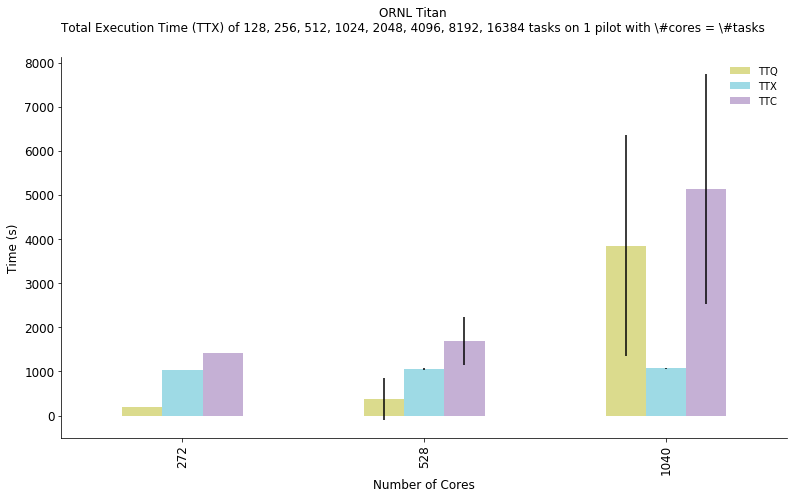

In [7]:
fig, ax = fig_setup()
title_head = 'ORNL Titan'
title_desc = 'Total Execution Time (TTX) of 128, 256, 512, 1024, 2048, 4096, 8192, 16384 tasks on 1 pilot with \#cores = \#tasks'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# TTX, TTQ and TTC mean and STD per number of cores requested
ttxqc = sessions5.ix[pilots5[pilots5['hid'] == 'titan'].sid][['ncore','U_AGENT_EXECUTING','P_LRMS_QUEUING','TTC']].groupby(['ncore'])
means = ttxqc.aggregate( {'P_LRMS_QUEUING'   :{'TTQ':'mean'},
                          'U_AGENT_EXECUTING':{'TTX':'mean'},
                          'TTC'              :{'TTC':'mean'}})
errors = ttxqc.aggregate({'P_LRMS_QUEUING'   :{'TTQ':'std'},
                          'U_AGENT_EXECUTING':{'TTX':'std'},
                          'TTC'              :{'TTC':'std'}})

means.columns = means.columns.droplevel(0)
errors.columns = errors.columns.droplevel(0)

means.plot(y=['TTQ','TTX','TTC'], 
           yerr=errors,
           color=[tableau20[15],tableau20[17],tableau20[9]],
           ax=ax,
           kind='bar')


ax.set_xlabel('Number of Cores')
ax.set_ylabel('Time (s)')

plt.savefig('figures/titan_ttq_ttx_ttc.pdf', dpi=600, bbox_inches='tight')

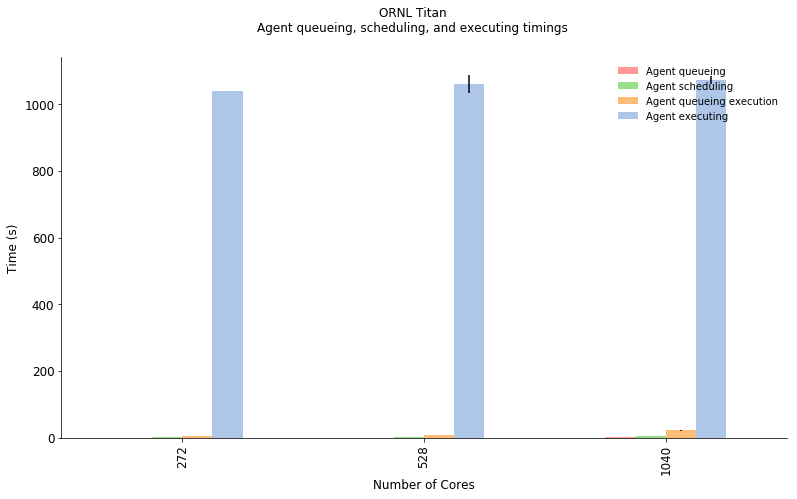

In [8]:
fig, ax = fig_setup()
title_head = 'ORNL Titan'
title_desc = 'Agent queueing, scheduling, and executing timings'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# 'U_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'            ],
# 'U_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'        , 'AGENT_EXECUTING_PENDING'     ],
# 'U_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING' , 'AGENT_EXECUTING'             ],
# 'U_AGENT_EXECUTING'   : ['AGENT_EXECUTING'         , 'AGENT_STAGING_OUTPUT_PENDING']}

atx = sessions5.ix[pilots5[pilots5['hid'] == 'titan'].sid][
        ['ncore',
         'U_AGENT_QUEUING', 
         'U_AGENT_SCHEDULING',  
         'U_AGENT_QUEUING_EXEC', 
         'U_AGENT_EXECUTING', 
         'TTC']].groupby(['ncore'])

means = atx.aggregate({'U_AGENT_QUEUING'     :{'Agent queueing'          :'mean'},
                       'U_AGENT_SCHEDULING'  :{'Agent scheduling'        :'mean'},
                       'U_AGENT_QUEUING_EXEC':{'Agent queueing execution':'mean'},
                       'U_AGENT_EXECUTING'   :{'Agent executing'         :'mean'},
                       'TTC'                 :{'Total execution time'    :'mean'}})

errors = atx.aggregate({'U_AGENT_QUEUING'     :{'Agent queueing'           :'std' },
                        'U_AGENT_SCHEDULING'  :{'Agent scheduling'         :'std' },
                        'U_AGENT_QUEUING_EXEC':{'Agent queueing execution' :'std' },
                        'U_AGENT_EXECUTING'   :{'Agent executing'          :'std' },
                        'TTC'                 :{'Total execution time'     :'std' }})

means.columns = means.columns.droplevel(0)
errors.columns = errors.columns.droplevel(0)

means.plot.bar(y=['Agent queueing','Agent scheduling','Agent queueing execution','Agent executing'], 
               yerr=errors,
               color=[tableau20[7],tableau20[5],tableau20[3],tableau20[1]], 
               ax=ax)

ax.set_xlabel('Number of Cores')
ax.set_ylabel('Time (s)')

#plt.savefig('figures/titan_agent_timings.pdf', dpi=600, bbox_inches='tight')

In [9]:
# load ra session objects.
path = '/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper/analysis/data/use_case_id_5_gromacs'

# sessions with 4096 units
snpilots = [1040]

# load the RA session objects 
# sras = {}

# sras_stampede = {}
# for snpilot in snpilots:
#     sras_stampede[snpilot] = []
#     s = sessions.loc[pilots[pilots['hid'] == 'stampede'].sid]
#     s = s[(s['nunit_requested'] == 4096)]
#     for sid in s['sid'].tolist():
#         exp = s.ix[sid]['experiment']
#         sras_stampede[snpilot].append(ra.Session(sid, 'radical.pilot', src='%s/%s/%s' % (path, exp, sid)))

sras_titan = {}
for snpilot in snpilots:
    sras_titan[snpilot] = []
    s = sessions5.loc[pilots5[pilots5['hid'] == 'titan'].sid]
    s = s[(s['nunit_requested'] == 1024.0)]
    for sid in s['sid'].tolist():
        exp = s.ix[sid]['experiment']
        sras_titan[snpilot].append(ra.Session(sid, 'radical.pilot', src='%s/%s/%s' % (path, exp, sid)))

ValueError: initial condition did not apply

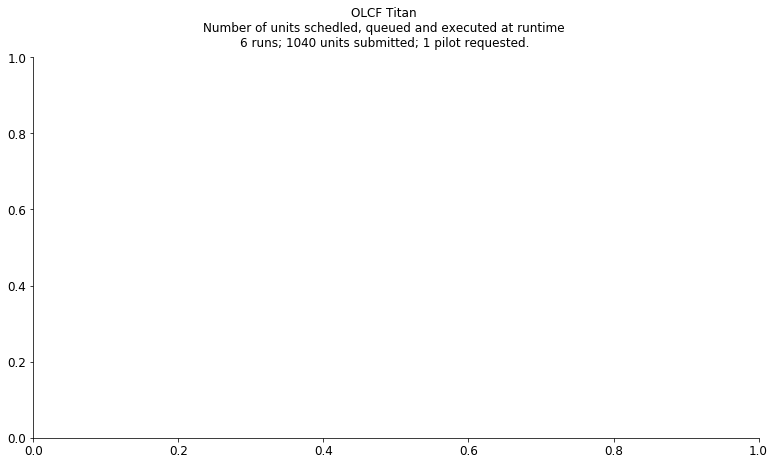

In [10]:
fig, ax = fig_setup()

title='OLCF Titan\n'+\
'Number of units schedled, queued and executed at runtime\n'+\
'6 runs; 1040 units submitted; 1 pilot requested.'
fig.suptitle(title)

for s1 in sras_titan[1040]:
    
    # Plot concurrent scheduled units
    scu = s1.concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[4])

    # Plot concurrent queued units
    scu = s1.concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[2])

    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Scheduled Units', 'Queued Execution Units', 'Executed Units'], loc=9)

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

# Analysis Experiment 1 -- Use Case 1 -- Synapse

In [11]:
sessions = pd.read_csv('data/use_case_id_1_synapse/sessions.csv', index_col=0)
pilots = pd.read_csv('data/use_case_id_1_synapse/pilots.csv', index_col=0)
units = pd.read_csv('data/use_case_id_1_synapse/units.csv', index_col=0)
profiles = pd.read_csv('data/use_case_id_1_synapse/stage3_amber_profiles.csv', index_col=0)

In [12]:
sessions.loc[(sessions['nunit'] >= 8   ) & (sessions['nunit'] < 16  ), 'nunit_requested'] = 8
sessions.loc[(sessions['nunit'] >= 16  ) & (sessions['nunit'] < 32  ), 'nunit_requested'] = 16
sessions.loc[(sessions['nunit'] >= 32  ) & (sessions['nunit'] < 64  ), 'nunit_requested'] = 32
sessions.loc[(sessions['nunit'] >= 64  ) & (sessions['nunit'] < 128 ), 'nunit_requested'] = 64
sessions.loc[(sessions['nunit'] >= 128 ) & (sessions['nunit'] < 256 ), 'nunit_requested'] = 128
sessions.loc[(sessions['nunit'] >= 256 ) & (sessions['nunit'] < 512 ), 'nunit_requested'] = 256
sessions.loc[(sessions['nunit'] >= 512 ) & (sessions['nunit'] < 1024), 'nunit_requested'] = 512
sessions.loc[(sessions['nunit'] >= 1024) & (sessions['nunit'] < 2048), 'nunit_requested'] = 1024
sessions.loc[(sessions['nunit'] >= 2048) & (sessions['nunit'] < 4096), 'nunit_requested'] = 2048
sessions.loc[(sessions['nunit'] >= 4096) & (sessions['nunit'] < 8192), 'nunit_requested'] = 4096

sessions['nunit_rescheduled'] = sessions['nunit'] - sessions['nunit_requested']

In [13]:
pilots.hid.replace(to_replace='stampede.tacc.utexas.edu', value='stampede', inplace=True)
pilots.hid.replace(to_replace='nid[0-9.]+', value='titan', inplace=True, regex=True)
pilots.hid.replace(to_replace='.*ornl.gov', value='titan', inplace=True, regex=True)

units.hid.replace(to_replace='stampede.tacc.utexas.edu', value='stampede', inplace=True)
units.hid.replace(to_replace='nid[0-9.]+', value='titan', inplace=True, regex=True)
units.hid.replace(to_replace='.*ornl.gov', value='titan', inplace=True, regex=True)

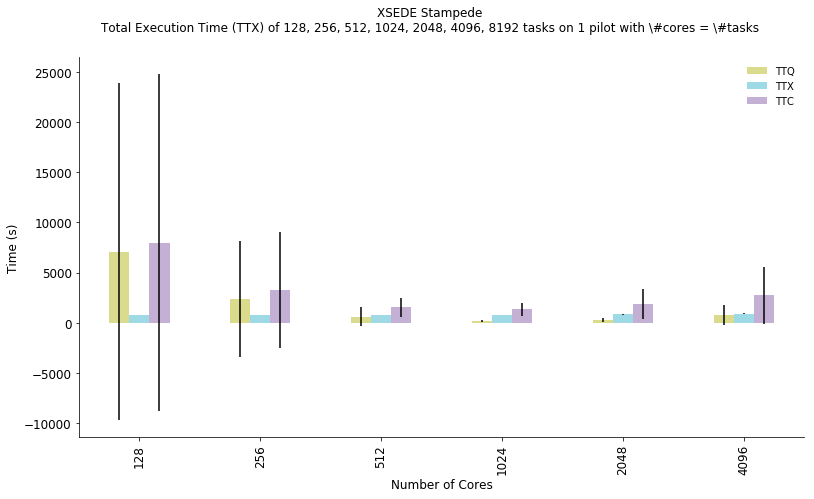

In [14]:
fig, ax = fig_setup()
title_head = 'XSEDE Stampede'
title_desc = 'Total Execution Time (TTX) of 128, 256, 512, 1024, 2048, 4096, 8192 tasks on 1 pilot with \#cores = \#tasks'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# TTX, TTQ and TTC mean and STD per number of cores requested on stampede
ttxqc = sessions.ix[pilots[pilots['hid'] == 'stampede'].sid][['ncore','U_AGENT_EXECUTING','P_LRMS_QUEUING','TTC']].groupby(['ncore'])
means = ttxqc.aggregate( {'P_LRMS_QUEUING'   :{'TTQ':'mean'},
                          'U_AGENT_EXECUTING':{'TTX':'mean'},
                          'TTC'              :{'TTC':'mean'}})
errors = ttxqc.aggregate({'P_LRMS_QUEUING'   :{'TTQ':'std'},
                          'U_AGENT_EXECUTING':{'TTX':'std'},
                          'TTC'              :{'TTC':'std'}})

means.columns = means.columns.droplevel(0)
errors.columns = errors.columns.droplevel(0)

means.plot(y=['TTQ','TTX','TTC'], 
           yerr=errors,
           color=[tableau20[15],tableau20[17],tableau20[9]],
           ax=ax,
           kind='bar')


ax.set_xlabel('Number of Cores')
ax.set_ylabel('Time (s)')

#plt.savefig('figures/stampede_ttq_ttx_ttc.pdf', dpi=600, bbox_inches='tight')

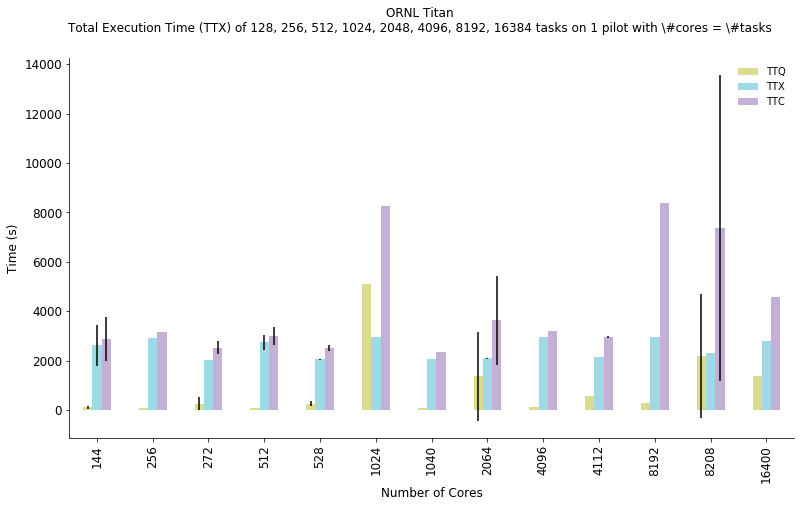

In [15]:
fig, ax = fig_setup()
title_head = 'ORNL Titan'
title_desc = 'Total Execution Time (TTX) of 128, 256, 512, 1024, 2048, 4096, 8192, 16384 tasks on 1 pilot with \#cores = \#tasks'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# TTX, TTQ and TTC mean and STD per number of cores requested
ttxqc = sessions.ix[pilots[pilots['hid'] == 'titan'].sid][['ncore','U_AGENT_EXECUTING','P_LRMS_QUEUING','TTC']].groupby(['ncore'])
means = ttxqc.aggregate( {'P_LRMS_QUEUING'   :{'TTQ':'mean'},
                          'U_AGENT_EXECUTING':{'TTX':'mean'},
                          'TTC'              :{'TTC':'mean'}})
errors = ttxqc.aggregate({'P_LRMS_QUEUING'   :{'TTQ':'std'},
                          'U_AGENT_EXECUTING':{'TTX':'std'},
                          'TTC'              :{'TTC':'std'}})

means.columns = means.columns.droplevel(0)
errors.columns = errors.columns.droplevel(0)

means.plot(y=['TTQ','TTX','TTC'], 
           yerr=errors,
           color=[tableau20[15],tableau20[17],tableau20[9]],
           ax=ax,
           kind='bar')


ax.set_xlabel('Number of Cores')
ax.set_ylabel('Time (s)')

#plt.savefig('figures/titan_ttq_ttx_ttc.pdf', dpi=600, bbox_inches='tight')

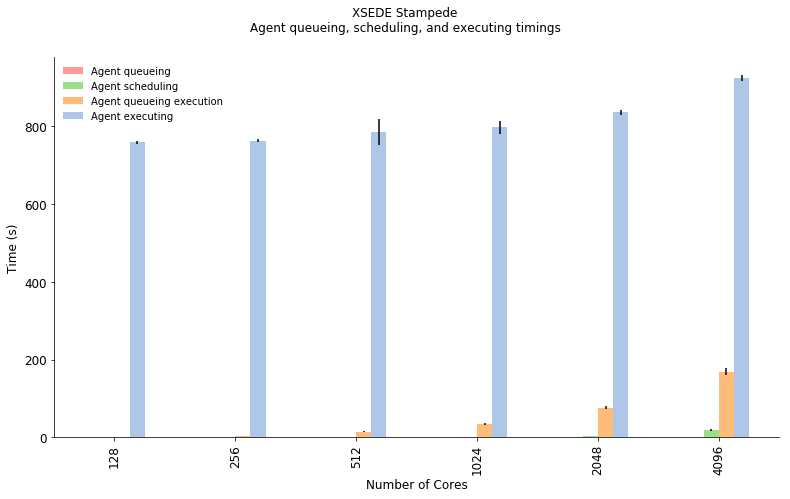

In [16]:
fig, ax = fig_setup()
title_head = 'XSEDE Stampede'
title_desc = 'Agent queueing, scheduling, and executing timings'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# 'U_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'            ],
# 'U_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'        , 'AGENT_EXECUTING_PENDING'     ],
# 'U_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING' , 'AGENT_EXECUTING'             ],
# 'U_AGENT_EXECUTING'   : ['AGENT_EXECUTING'         , 'AGENT_STAGING_OUTPUT_PENDING']}

atx = sessions.ix[pilots[pilots['hid'] == 'stampede'].sid][
        ['ncore',
         'U_AGENT_QUEUING', 
         'U_AGENT_SCHEDULING',  
         'U_AGENT_QUEUING_EXEC', 
         'U_AGENT_EXECUTING', 
         'TTC']].groupby(['ncore'])

means = atx.aggregate({'U_AGENT_QUEUING'     :{'Agent queueing'          :'mean'},
                       'U_AGENT_SCHEDULING'  :{'Agent scheduling'        :'mean'},
                       'U_AGENT_QUEUING_EXEC':{'Agent queueing execution':'mean'},
                       'U_AGENT_EXECUTING'   :{'Agent executing'         :'mean'},
                       'TTC'                 :{'Total execution time'    :'mean'}})

errors = atx.aggregate({'U_AGENT_QUEUING'     :{'Agent queueing'           :'std' },
                        'U_AGENT_SCHEDULING'  :{'Agent scheduling'         :'std' },
                        'U_AGENT_QUEUING_EXEC':{'Agent queueing execution' :'std' },
                        'U_AGENT_EXECUTING'   :{'Agent executing'          :'std' },
                        'TTC'                 :{'Total execution time'     :'std' }})

means.columns = means.columns.droplevel(0)
errors.columns = errors.columns.droplevel(0)

means.plot.bar(y=['Agent queueing','Agent scheduling','Agent queueing execution','Agent executing'], 
               yerr=errors,
               color=[tableau20[7],tableau20[5],tableau20[3],tableau20[1]], 
               ax=ax)

ax.set_xlabel('Number of Cores')
ax.set_ylabel('Time (s)')

#plt.savefig('figures/stampede_agent_timings.pdf', dpi=600, bbox_inches='tight')

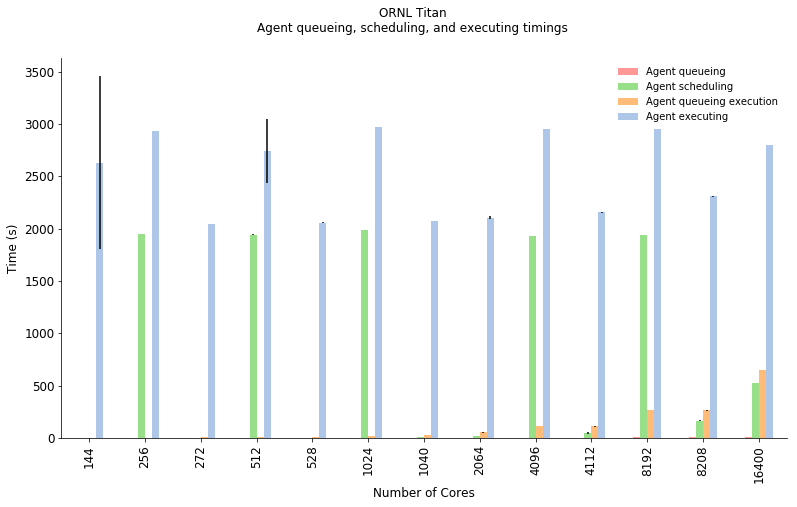

In [17]:
fig, ax = fig_setup()
title_head = 'ORNL Titan'
title_desc = 'Agent queueing, scheduling, and executing timings'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

# 'U_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'            ],
# 'U_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'        , 'AGENT_EXECUTING_PENDING'     ],
# 'U_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING' , 'AGENT_EXECUTING'             ],
# 'U_AGENT_EXECUTING'   : ['AGENT_EXECUTING'         , 'AGENT_STAGING_OUTPUT_PENDING']}

atx = sessions.ix[pilots[pilots['hid'] == 'titan'].sid][
        ['ncore',
         'U_AGENT_QUEUING', 
         'U_AGENT_SCHEDULING',  
         'U_AGENT_QUEUING_EXEC', 
         'U_AGENT_EXECUTING', 
         'TTC']].groupby(['ncore'])

means = atx.aggregate({'U_AGENT_QUEUING'     :{'Agent queueing'          :'mean'},
                       'U_AGENT_SCHEDULING'  :{'Agent scheduling'        :'mean'},
                       'U_AGENT_QUEUING_EXEC':{'Agent queueing execution':'mean'},
                       'U_AGENT_EXECUTING'   :{'Agent executing'         :'mean'},
                       'TTC'                 :{'Total execution time'    :'mean'}})

errors = atx.aggregate({'U_AGENT_QUEUING'     :{'Agent queueing'           :'std' },
                        'U_AGENT_SCHEDULING'  :{'Agent scheduling'         :'std' },
                        'U_AGENT_QUEUING_EXEC':{'Agent queueing execution' :'std' },
                        'U_AGENT_EXECUTING'   :{'Agent executing'          :'std' },
                        'TTC'                 :{'Total execution time'     :'std' }})

means.columns = means.columns.droplevel(0)
errors.columns = errors.columns.droplevel(0)

means.plot.bar(y=['Agent queueing','Agent scheduling','Agent queueing execution','Agent executing'], 
               yerr=errors,
               color=[tableau20[7],tableau20[5],tableau20[3],tableau20[1]], 
               ax=ax)

ax.set_xlabel('Number of Cores')
ax.set_ylabel('Time (s)')

#plt.savefig('figures/titan_agent_timings.pdf', dpi=600, bbox_inches='tight')

In [18]:
# load ra session objects.
path = '/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper/analysis/data/use_case_id_1_synapse'

# sessions with 4096 units
snpilots = [4096]

# load the RA session objects 
sras = {}

sras_stampede = {}
for snpilot in snpilots:
    sras_stampede[snpilot] = []
    s = sessions.loc[pilots[pilots['hid'] == 'stampede'].sid]
    s = s[(s['nunit_requested'] == 4096)]
    for sid in s['sid'].tolist():
        exp = s.ix[sid]['experiment']
        sras_stampede[snpilot].append(ra.Session(sid, 'radical.pilot', src='%s/%s/%s' % (path, exp, sid)))

sras_titan = {}
for snpilot in snpilots:
    sras_titan[snpilot] = []
    s = sessions.loc[pilots[pilots['hid'] == 'titan'].sid]
    s = s[(s['nunit_requested'] == 4096)]
    for sid in s['sid'].tolist():
        exp = s.ix[sid]['experiment']
        sras_titan[snpilot].append(ra.Session(sid, 'radical.pilot', src='%s/%s/%s' % (path, exp, sid)))

ValueError: initial condition did not apply

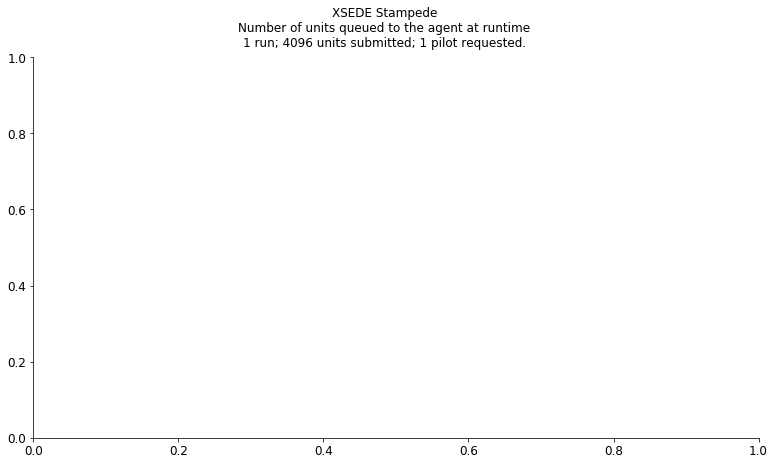

In [19]:
fig, ax = fig_setup()

title='XSEDE Stampede\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='ORNL Titan\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan[4096][0].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='XSEDE Stampede\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='ORNL Titan\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan[4096][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='XSEDE Stampede\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='ORNL Titan\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan[4096][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='XSEDE Stampede\n'+\
'Number of units schedled, queued and executed at runtime\n'+\
'6 runs; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

for s1 in sras_stampede[4096]:
    
    # Plot concurrent scheduled units
    scu = s1.concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[4])

    # Plot concurrent queued units
    scu = s1.concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[2])

    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Scheduled Units', 'Queued Execution Units', 'Executed Units'], loc=9)

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan\n'+\
'Number of units schedled, queued and executed at runtime\n'+\
'6 runs; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

for s1 in sras_titan[4096]:
    
    # Plot concurrent scheduled units
    scu = s1.concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[4])

    # Plot concurrent queued units
    scu = s1.concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[2])

    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Scheduled Units', 'Queued Execution Units', 'Executed Units'], loc=9)

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='XSEDE Stampede\n'+\
'Number of units scheduled, queued, and executed runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent scheduled units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Active Units')
ax.legend(labels=['Scheduled Units', 'Queued Execution Units', 'Executed Units'])

plt.savefig('figures/stampede_agent_state_concurrency_4096.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='ORNL Titan\n'+\
'Number of units scheduled, queued, and executed runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent scheduled units
scu = sras_titan[4096][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras_titan[4096][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras_titan[4096][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Active Units')
ax.legend(labels=['Scheduled Units', 'Queued Execution Units', 'Executed Units'])

plt.savefig('figures/titan_agent_state_concurrency_4096.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='XSEDE Stampede and ORNL Titan\n'+\
'Number of units scheduled, queued, and executed runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent scheduled units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[5])

# Plot concurrent queued units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[3])

# Plot concurrent active units
scu = sras_stampede[4096][3].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[1])

# Plot concurrent scheduled units
scu = sras_titan[4096][0].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras_titan[4096][0].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras_titan[4096][0].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Active Units')
ax.legend(labels=['Stampede Scheduled Units', 
                  'Stampede Queued Execution Units', 
                  'Stampede Executed Units', 
                  'Titan Scheduled Units', 
                  'Titan Queued Execution Units', 
                  'Titan Executed Units'])

plt.savefig('figures/stampede_titan_agent_state_concurrency_4096.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()
title='XSEDE Stampede\nDensity of Task Execution Time (Tx)'

# KDE execution time
ustampede = units[units['hid'] == 'stampede']

display(sps.normaltest(ustampede['U_AGENT_EXECUTING'].dropna().tolist()))
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

plt.xlabel('Time (s)')
ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/stampede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()
title='ORNL Titan\nDensity of Task Execution Time (Tx)'

# KDE execution time
utitan = units[units['hid'] == 'titan']

display(sps.normaltest(utitan['U_AGENT_EXECUTING'].dropna().tolist()))
utitan[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
utitan[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(utitan['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

plt.xlabel('Time (s)')
ax.legend(labels=['Task Execution Time (Tx)', 'Mean'])

plt.savefig('figures/titan_tx_frequency.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()
title='XSEDE Stampede and ORNL Titan\nDensity of Task Execution Time (Tx)'

# Stampede KDE execution time
ustampede = units[units['hid'] == 'stampede']

ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Stampede Normed Histogram 
ustampede[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=30, 
                alpha = 0.20,
                normed=True)

# Titan KDE execution time
utitan = units[units['hid'] == 'titan']

utitan[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(ax=ax, color='blue', title=title)

# Normed Histogram 
utitan[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=30, 
                alpha = 0.20,
                normed=True)

plt.axvline(ustampede['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(utitan['U_AGENT_EXECUTING'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)

plt.xlabel('Time (s)')
ax.legend(labels=['Stampede Task Execution Time (Tx)',
                  'Titan Task Execution Time (Tx)',
                  'Mean'])

plt.savefig('figures/stampede_titan_tx_frequency.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()
title='Stampede XSEDE\nDensity of number of FLOPS for all the Synapse profiles of the AMBER workload'

# KDE FLOPS profiles
display(sps.normaltest(units['U_AGENT_EXECUTING'].dropna().tolist()))
profiles[['FLOPS']].dropna().reset_index(drop=True).plot.density(ax=ax, color='black', title=title)

# Normed Histogram 
profiles[['FLOPS']].dropna().reset_index(drop=True).plot.hist(
                ax=ax, 
                color='gray', 
                bins=10, 
                alpha = 0.20,
                normed=True)

plt.axvline(profiles['FLOPS'].dropna().mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(1715750072310, color='g', linestyle='dashed', linewidth=1)

ax.legend(labels=['Number of FLOPS', 'Mean', 'FLOPS OSG Experiments'])

#plt.savefig('figures/stampede_tx_frequency.pdf', dpi=600, bbox_inches='tight')

## Titan Atlas

In [ ]:
# load ATLAS sessions, pilots, units
sessions_atlas = pd.read_csv('/Users/mturilli/Projects/RADICAL/github/experiments/misc/atlas-paper-experiments/weak2/sessions.csv', index_col=0)
pilots_atlas = pd.read_csv('/Users/mturilli/Projects/RADICAL/github/experiments/misc/atlas-paper-experiments/weak2/pilots.csv', index_col=0)
units_atlas = pd.read_csv('/Users/mturilli/Projects/RADICAL/github/experiments/misc/atlas-paper-experiments/weak2/units.csv', index_col=0)

# set host name
pilots_atlas.hid = 'titan'

In [ ]:
# load ra session objects for ATLAS.
path_atlas = '/Users/mturilli/Projects/RADICAL/github/experiments/misc/atlas-paper-experiments/weak2'

# sessions with 16400 units
snpilots_atlas = [1]

sras_titan_atlas = {}
for snpilot in snpilots_atlas:
    sras_titan_atlas[snpilot] = []
    s = sessions_atlas.loc[pilots_atlas[pilots_atlas['hid'] == 'titan'].sid]
    s = s[(s['nunit'] == 5120)]
    for sid in s['sid'].tolist():
        print sid
        exp = s.ix[sid]['experiment']
        sras_titan_atlas[snpilot].append(ra.Session(sid, 'radical.pilot', src='%s/%s/%s' % (path_atlas, exp, sid)))

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan%s\n' % sras_titan_atlas[1][7]._sid+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 5120 units submitted; 1 16400 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][3].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan%s\n' % sras_titan_atlas[1][7]._sid+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 5120 units submitted; 1 16400 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][7].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan\n'+\
'Number of units queued to the agent at runtime\n'+\
'3 runs; 5120 units submitted; 1 16400 pilot requested.'
fig.suptitle(title)

c = 0
for s1 in sras_titan_atlas[1]:
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[c])
    c+=2

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

ax.set_yscale('log', basey=2)
ax.set_xlim(0, 2250)
ax.set_ylim(0, 2**13)

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan%s\n' % sras_titan_atlas[1][7]._sid+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 5120 units submitted; 1 16400 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][3].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan - session %s\n' % sras_titan_atlas[1][7]._sid+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 5120 units submitted; 1 16400 pilot requested.' 
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][7].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 5120 units submitted; 1 16400 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][3].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 5120 units submitted; 1 16400 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][7].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

plt.xlabel('Time (s)')
plt.ylabel('Number of Queued Units to the Agent')

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='OLCF Titan\n'+\
'Number of units queued to the agent at runtime\n'+\
'1 run; 5120 units submitted; 1 16400 pilot requested.'
fig.suptitle(title)

for s1 in sras_titan_atlas[1]:
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[6])

    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[4])

    scu = s1.concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[2])
    
    # Plot concurrent active units
    scu = s1.concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
    x = [item[0] for item in scu]
    y = [item[1] for item in scu]
    ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Units')
ax.legend(labels=['Receiving Units', 'Scheduled Units', 'Queued Execution Units', 'Executed Units'])

# plt.savefig('figures/osg_nactive-concurrent-pilots_64.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='ORNL Titan\n'+\
'Number of units scheduled, queued, and executed runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][3].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras_titan_atlas[1][3].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras_titan_atlas[1][3].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras_titan_atlas[1][3].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Active Units')
ax.legend(labels=['Receiving Units', 'Scheduled Units', 'Queued Execution Units', 'Executed Units'])

plt.savefig('figures/titan_agent_state_concurrency_4096.pdf', dpi=600, bbox_inches='tight')

In [ ]:
fig, ax = fig_setup()

title='ORNL Titan\n'+\
'Number of units scheduled, queued, and executed runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][7].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras_titan_atlas[1][7].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras_titan_atlas[1][7].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras_titan_atlas[1][7].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Active Units')
ax.legend(labels=['Receiving Units', 'Scheduled Units', 'Queued Execution Units', 'Executed Units'])

ax.set_yscale('log', basey=2)

plt.savefig('figures/titan_agent_state_concurrency_4096.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# rp.session.titan-ext1.aleang9.017238.0009
# sras_titan_atlas[1][2]._sid
units_atlas[units_atlas.sid == 'rp.session.titan-ext1.aleang9.017238.0009'].U_AGENT_QUEUING_EXEC#.mean()


In [ ]:
fig, ax = fig_setup()

title='ORNL Titan\n'+\
'Number of units scheduled, queued, and executed runtime\n'+\
'1 run; 4096 units submitted; 1 pilot requested.'
fig.suptitle(title)

# Plot concurrent active units
scu = sras_titan_atlas[1][2].concurrency(state=['AGENT_SCHEDULING_PENDING', 'AGENT_SCHEDULING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[6])

# Plot concurrent scheduled units
scu = sras_titan_atlas[1][2].concurrency(state=['AGENT_SCHEDULING', 'AGENT_EXECUTING_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[4])

# Plot concurrent queued units
scu = sras_titan_atlas[1][2].concurrency(state=['AGENT_EXECUTING_PENDING', 'AGENT_EXECUTING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[2])

# Plot concurrent active units
scu = sras_titan_atlas[1][2].concurrency(state=['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y, color=tableau20[0])

plt.xlabel('Time (s)')
plt.ylabel('Number of Active Units')
ax.legend(labels=['Receiving Units', 'Scheduled Units', 'Queued Execution Units', 'Executed Units'])

ax.set_yscale('log', basey=2)

plt.savefig('figures/titan_agent_state_concurrency_rp.session.titan-ext1.aleang9.017238.0009.pdf', dpi=600, bbox_inches='tight')



In [ ]:
ps = {
    'nunit': [8192], 
    'P_PMGR_QUEUING': [0.0017998218536376953], 
    'FAILED': [3008.876300096512], 
    'P_LRMS_SUBMITTING': [59.23070001602173], 
    'PMGR_LAUNCHING': [3.990000009536743], 
    'PMGR_ACTIVE': [490.8173999786377], 
    'ncore': [8208], 
    'P_LRMS_RUNNING': [2518.058900117874], 
    'pid': [u'pilot.0000'], 
    'P_LRMS_QUEUING': [427.5966999530792], 
    'CANCELED': [np.nan], 
    'experiment': ['exp1'], 
    'hid': ['ccs.ornl.gov'], 
    'PMGR_LAUNCHING_PENDING': [3.9882001876831055], 
    'P_PMGR_SCHEDULING': [0.11510014533996582], 
    'sid': ['rp.session.titan-ext1.merzky1.017242.0012'], 'PMGR_ACTIVE_PENDING': [63.22070002555847], 
    'DONE': [np.nan], 
    'NEW': [3.8731000423431396]
}
pilots = pd.DataFrame(ps)